In [1]:
library(data.table)
#require(xlsx)
library(readxl)
library(readxlsb)
library(data.table)
library(rpart)
library(rpart.plot)
library(readxl)
library(stringr)
library(pmml)
library(partykit)

Loading required package: XML

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm



In [2]:

library(ranger)
library(xgboost)
library(ggplot2)
library(ROCR)
library(SHAPforxgboost)

In [11]:
##lettura dati EWS
dt_ews <- read_xlsx('data/EWS_ceduti_enriched.xlsx', sheet = 'CEDUTI_ENRICHED')
colnames(dt_ews)<- tolower(colnames(dt_ews))
setDT(dt_ews)
dt_ews[,d_riferimento := as.Date(d_riferimento)]
col_ews_pred <- colnames(dt_ews)[grepl("pred",colnames(dt_ews))]

In [12]:
## Lettura dati VPC con nuove colonne
excel_sheets('data/DB_FINALE_INTEGRATO_v01.xlsx')
#dtv2 <- readRDS('data/DB_FINALE_INTEGRATO_v01.RDS')

[1] "QUERY_FOR_DB_FINALE_INTEGRATO"

In [13]:


# dtv1 <- read_excel('data/DB_FINALE_INTEGRATO_v01.xlsx', sheet = 'QUERY_FOR_DB_FINALE_INTEGRATO')
# colnames(dtv1)<- tolower(colnames(dtv1))
# setDT(dtv1)

# dtv1[,data_richiesta := as.Date(substr(data_delibera_o_annull_fido,1,10))]
# saveRDS(dtv1,'data/DB_FINALE_INTEGRATO_v01.RDS')

# ## Lettura dati VPC con nuove colonne
# excel_sheets('data/DB_FINALE_INTEGRATO_v02.xlsx')
# #dtv2 <- readRDS('data/DB_FINALE_INTEGRATO_v01.RDS')
# dtv2 <- read_xlsx('data/DB_FINALE_INTEGRATO_v02.xlsx', sheet = 'DB')
# colnames(dtv2)<- tolower(colnames(dtv2))
# setDT(dtv2)

# #colonne utili

# # presenza_fido_580_590_c
# # ft factoring
# # rating_attuale_ricondotto
# # delta_applicazione
# # macrosegmento_attuale
# # cod_colore_classe_t0
# # tipo operazione concessa applica   ---- rappresenta l'esito finale della vpc dopo il giallo


# col_to_rm <- intersect(colnames(dtv2),colnames(dtv1))
# dt2 <- copy(dtv2[,c('num_pratica', 'progress_pratica', setdiff(colnames(dtv2),col_to_rm)),with = FALSE])
# colnames(dt2)

# dt_to_save <- merge(dtv1,dt2,by = c('num_pratica', 'progress_pratica'), all = TRUE)

# saveRDS(dt_to_save,'data/DB_FINALE_INTEGRATO_v02.RDS')

In [109]:
## Lettura dati VPC (già salvati in RDS e con il tolower delle colonne)
dt <- readRDS('data/DB_FINALE_INTEGRATO_v02.RDS')


In [110]:
### FIltro il DB eliminando le controparti già in default prima dell'osservazione. 

dt <- dt[`perimetro analisi descrittive` == 1 & `perimetro_finale_analisi td` == 1 & `perimetro_no_default_t0` == 1 ,]
dt[,target :='OK']
dt[`perimetro_si_default_tfinal` == 1, target := 'DEFAULT']

cat('Default in Verde',round(100*nrow(dt[target=='DEFAULT' &esito_finale_vpc=='VERDE' ,])/
                            nrow(dt[esito_finale_vpc=='VERDE' ,]),3),"%")
cat('\nDefault in Giallo',round(100*nrow(dt[target=='DEFAULT' &esito_finale_vpc=='GIALLO' ,])/
                             nrow(dt[esito_finale_vpc=='GIALLO' ,]),3),"%")
cat('\nDefault in Rosso',round(100*nrow(dt[target=='DEFAULT' &esito_finale_vpc=='ROSSO' ,])/
                            nrow(dt[esito_finale_vpc=='ROSSO' ,]),3),"%")


Default in Verde 2.644 %
Default in Giallo 2.537 %
Default in Rosso 6.091 %

In [111]:
saveRDS(dt,'data/DB_perimetro.RDS')

In [16]:
dt[esito_finale_vpc %in% c('VERDE',"ROSSO"), esito_post_giallo := esito_finale_vpc]
dt[`tipo operazione concessa applica` %in% c('CONCESSIONE',"AUMENTO") & esito_finale_vpc =='GIALLO', esito_post_giallo := "VERDE"]
dt[!(`tipo operazione concessa applica` %in% c('CONCESSIONE',"AUMENTO"))& esito_finale_vpc =='GIALLO', esito_post_giallo := "ROSSO"]

In [17]:
pdo_ews <- as.Date(sort((unique(dt_ews$d_riferimento))))

In [18]:
pdo_ews

[1] "2017-12-31" "2018-06-30" "2018-12-31" "2019-06-30"

In [19]:
dt[,flag_d_riferimento := findInterval(data_richiesta, pdo_ews)]
dt[,d_riferimento := min(pdo_ews)]
dt[flag_d_riferimento >1 ,d_riferimento := pdo_ews[flag_d_riferimento]]
#dt[,flag_d_riferimento := NULL]

In [20]:
head(dt[flag_d_riferimento ==0, c('d_riferimento', 'flag_d_riferimento','data_richiesta')])

d_riferimento,flag_d_riferimento,data_richiesta
<date>,<int>,<date>
2017-12-31,0,2016-02-09
2017-12-31,0,2016-01-15
2017-12-31,0,2016-01-05
2017-12-31,0,2016-01-22
2017-12-31,0,2016-02-24
2017-12-31,0,2016-04-21


In [21]:
### left join con gli indicatori di EWS, bisogna capire qual è il PDO giusto da considerare
dt1<- merge(x = dt, y = dt_ews, by = c("sndg_ceduto",'d_riferimento'), all.x = TRUE)
dt1<- dt1[!is.na(sndg_ceduto),]

In [22]:
table(dt1[esito_finale_vpc=='GIALLO', esito_post_giallo])


ROSSO VERDE 
 4826 22019 

In [23]:
## elimino le colonne con tutti NA
train<- dt1[,which(unlist(lapply(dt1, function(x)!all(is.na(x))))),with=F]
 

In [24]:

train2 <- cbind.data.frame(lapply(train, function(x) {
  if (all(unique(x) %in% c(0,1)))
    as.factor(c("NO", "YES")[x+1])
  else if (all(is.character(x)))
    as.factor(x)
  else
    x
}))
setDT(train2)

In [25]:
## Cerco le colonne con variabili di input 
colnames(train2) <- gsub("input - ", "",colnames(train2))
colnames(train2) <- gsub(" ", "_",colnames(train2))

## Cerco le colonne con variabili non siano né colore né esito
cols_var_all <- colnames(train2)[!grepl('colore -',colnames(train2)) &!grepl('esito -',colnames(train2))]


In [26]:
colnames(train2)[grepl('cedente',colnames(train2))]

[1] "ndg_cedente"                      "sndg_cedente"                    
 [3] "codice_fiscale_cedente"           "id_cedente"                      
 [5] "stato_cedente"                    "descr_stato_cedente"             
 [7] "filiale_cedente"                  "settore_cedente"                 
 [9] "colore_-_cedente_revocato"        "colore_-_cedente_travel"         
[11] "colore_-_soggetto_cedente"        "esito_-_presenza_di_fidi_cedente"
[13] "esito_-_soggetto_cedente"         "cedente_revocato"                
[15] "cedente_travel"                   "presenza_di_fidi_cedente"        
[17] "soggetto_cedente"                 "rae_cedente"                     
[19] "rae_descr_cedente"                "sae_cedente"                     
[21] "sae_descr_cedente"                "cib_bdt_cedente"                 
[23] "prefisso_mod_rating_cedente"      "rating_cedente"                  
[25] "sag_cedente"                      "ragio_sociale_cedente"           
[27] "id_cedente...34"                  "id_cedente_appoggio"             
[29] "id_cedente...228"

In [27]:

dt_appo <- train2[,c('cedente_revocato','cedente_travel','tipo_operazione_riduzion','ft_factoring','target','pred','esito_finale_vpc','esito_post_giallo',
                     'rating_attuale_ricondotto','delta_applicazione',
                     'macrosegmento_attuale','cod_colore_classe_t0'), with = FALSE]
dt_appo$target <- factor(dt_appo$target, levels = c('OK',"DEFAULT"))

In [28]:
#dt_appo[,`input - rating scaduto`:= str_sub(`input - rating scaduto`,-2,-1)]

In [29]:
table(dt_appo$rating_attuale_ricondotto, useNA = 'ifany')


ALTRO     D     I     M     R    UR  <NA> 
  433  4161 51701 58903  8863  3819  8210 

In [30]:
nrow(dt_appo)*0.7

[1] 95263

In [31]:
dt_appo_train <- dt_appo[,!(colnames(dt_appo) %in% c('esito_finale_vpc','esito_post_giallo')), with = FALSE]


In [32]:
slcols <- colnames(dt_appo)[!(colnames(dt_appo) %in% c('esito_finale_vpc','esito_post_giallo','target'))]

In [33]:
colnames(dt_appo)

[1] "cedente_revocato"          "cedente_travel"           
 [3] "tipo_operazione_riduzion"  "ft_factoring"             
 [5] "target"                    "pred"                     
 [7] "esito_finale_vpc"          "esito_post_giallo"        
 [9] "rating_attuale_ricondotto" "delta_applicazione"       
[11] "macrosegmento_attuale"     "cod_colore_classe_t0"

In [46]:
set.seed(1704)
rows <- sample(1:nrow(dt_appo_train), 100000, replace=F)
modello2 <- rpart(target ~ pred+cod_colore_classe_t0,
                data=dt_appo_train[rows,],
                method="class", control=rpart.control(cp = 1e-3, usesurrogate = 0))#metodo class o anova 

In [38]:
pred_mod2<- predict(modello2,dt_appo[-rows,])
pred_mod2<- as.data.table(pred_mod2)

dt_appo_pred <- dt_appo[-rows,] 
dt_appo_pred$pred_vpc <- pred_mod2$DEFAULT

table(dt_appo_pred[,c('pred_vpc','target','esito_finale_vpc')])

In [41]:
(dt_appo_pred[esito_finale_vpc == "GIALLO",c('pred_vpc','target','esito_finale_vpc', 'esito_post_giallo')][order(-pred_vpc,-target), ])

pred_vpc,target,esito_finale_vpc,esito_post_giallo
<dbl>,<fct>,<fct>,<fct>
0.7563025,DEFAULT,GIALLO,VERDE
0.7563025,DEFAULT,GIALLO,ROSSO
0.7563025,DEFAULT,GIALLO,VERDE
0.7563025,DEFAULT,GIALLO,VERDE
0.7563025,DEFAULT,GIALLO,ROSSO
0.7563025,OK,GIALLO,ROSSO
0.7563025,OK,GIALLO,VERDE
0.7500000,OK,GIALLO,VERDE
0.6285714,DEFAULT,GIALLO,VERDE


In [42]:
pred_ok <-unlist(pred_mod2[,1])

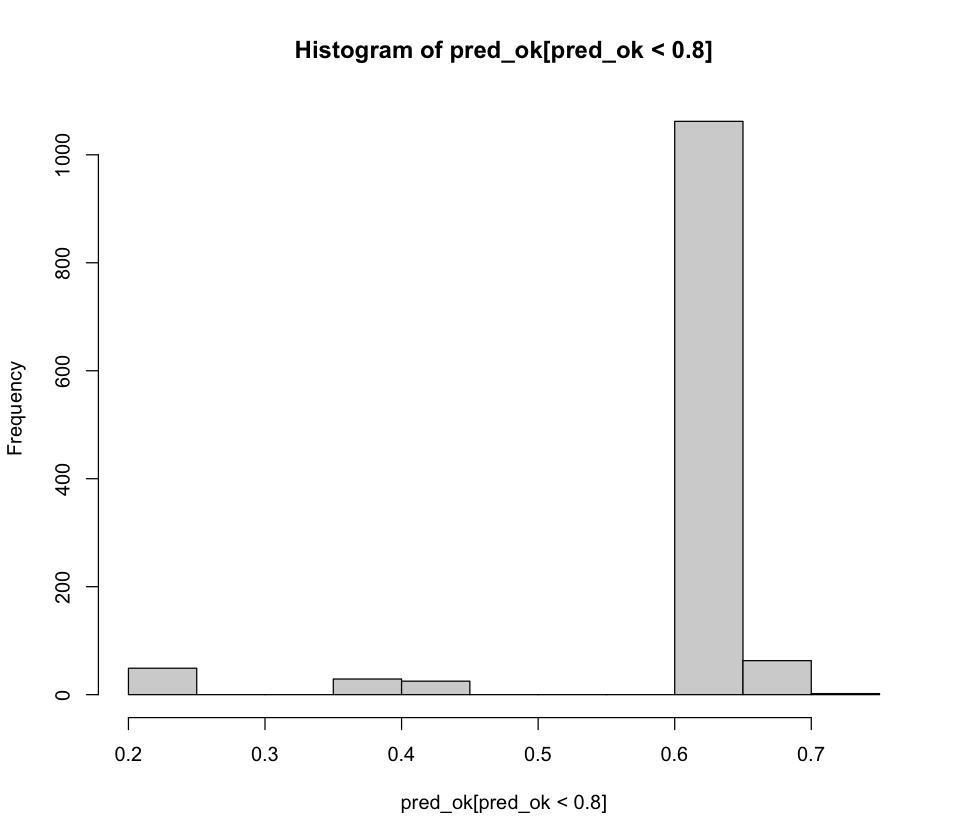

In [43]:
hist(pred_ok[pred_ok<0.80])

In [44]:
table(pred_mod2[,1]>0.75,dt_appo[-rows,target] )

       
           OK DEFAULT
  FALSE   632     596
  TRUE  34356     506

In [47]:
options(repr.plot.width=8, repr.plot.height=7)
pdf('prova.pdf')
rpart.plot(modello2, type=2, fallen.leaves=F, yesno=2, extra = 107,box.palette="-RdGn")
dev.off()

pdf 
  2

In [ ]:
pmod2 <- pmml(modello2, model_name = "VPC Tree Model",
app_name = NULL,
description = NULL,
copyright = NULL)

In [ ]:
saveXML(pmod2, file="~/Downloads/treetest_nosurrogate.xml")

In [ ]:
require(xml2)

In [ ]:
model <- xmlParse( "~/Downloads/provaxml.xml")

In [ ]:
(model)

In [81]:
library(data.tree)

In [ ]:
list_model <- xmlToList(model)


In [ ]:
list_model

In [108]:
mod_prova <- pmmlTreeModel("~/Downloads/prova_pmml_online.xml")


Warning message in extract_terms(obj):
“not yet implemented”


ERROR: Error in as.party.XMLNode(XML::xmlRoot(XML::xmlTreeParse(file))): inherits(mf_response, "factor") is not TRUE


In [84]:
obj <- XML::xmlRoot(XML::xmlTreeParse("~/Downloads/treetest_prova.xml"))

In [85]:
stopifnot(c("DataDictionary", "TreeModel") %in% names(obj))
  if(any(warnx <- c("MiningBuildTask", "TransformationDictionary", "Extension") %in% names(obj)))
    warning(sprintf("%s not yet implemented", paste(names(obj)[warnx], collapse = ", ")))
  
  ## process header information
  if("Header" %in% names(obj)) {
    hdr <- obj[["Header"]]
    h_info <- c(Header = paste(as.character(XML::xmlAttrs(hdr)), collapse = ", "))
    if(length(hdr) > 0L) {
      h_info <- c(h_info,
        XML::xmlSApply(hdr, function(x)
	  paste(c(as.character(XML::xmlAttrs(x)), XML::xmlValue(x)), collapse = ", ")
	)
      )
    }
  } else {
    h_info <- NULL
  }

In [86]:

  ## parse data dictionary
  extract_empty_model_frame <- function(x) {

    ## extract DataDictionary
    dd <- x[["DataDictionary"]]

    ## currently we can only look at DataField  
    if(!all(names(dd) == "DataField")) warning("data specifications other than DataField are not yet implemented")
  
    ## check columns
    nc <- as.numeric(XML::xmlAttrs(dd)["numberOfFields"])
    if(!is.na(nc)) stopifnot(nc == length(dd))

    ## set up data frame (only numeric variables)
    mf <- as.data.frame(rep(list(1), nc))[0,]
    names(mf) <- XML::xmlSApply(dd, function(x) XML::xmlAttrs(x)["name"])

    ## modify class if necessary
    for(i in 1:nc) {
      optype <- XML::xmlAttrs(dd[[i]])["optype"]
      switch(optype,
        "categorical" = {
           mf[[i]] <- factor(integer(0),
	     levels = XML::xmlSApply(dd[[i]], function(x) gsub("&amp;", "&", XML::xmlAttrs(x)["value"], fixed = TRUE)))
        },
        "ordinal" = {
           mf[[i]] <- factor(integer(0), ordered = TRUE,
	     levels = XML::xmlSApply(dd[[i]], function(x) gsub("&amp;", "&", XML::xmlAttrs(x)["value"], fixed = TRUE)))
        },
        "continuous" = {
          dataType <- XML::xmlAttrs(dd[[i]])["dataType"]
          if(dataType == "integer") mf[[i]] <- integer(0)
        }
      )
    }
    
    return(mf)
  }

In [87]:
mf <- extract_empty_model_frame(obj)
  mf_names <- names(mf)
  mf_levels <- lapply(mf, levels)


In [88]:
  ## parse MiningSchema
  extract_terms <- function(x) {

    ## extract MiningSchema
    ms <- x[["TreeModel"]]
    stopifnot("MiningSchema" %in% names(ms))
    ms <- ms[["MiningSchema"]]
    
    ## currently we can only look at MiningField  
    if(!all(names(ms) == "MiningField")) warning("MiningField not yet implemented")
    
    ## extract variable info
    vars <- t(XML::xmlSApply(ms, XML::xmlAttrs))
    if(sum(vars[,2] == "predicted") > 1) stop("multivariate responses not yet implemented")
    if(!all(vars[,2] %in% c("predicted", "active", "supplementary"))) warning("not yet implemented")
    
    ## set up formula
    ff <- as.formula(paste(vars[vars[,2] == "predicted",1], "~",
      paste(vars[vars[,2] != "predicted",1], collapse = " + ")))

    return(terms(ff))
  }

In [89]:
trms <- extract_terms(obj)
  
  ## parse TreeModel
  tm <- obj[["TreeModel"]]
  tm_info <- c(XML::xmlAttrs(tm), h_info)

  ## check response
  stopifnot(tm_info["functionName"] %in% c("classification", "regression"))
  mf_response <- mf[[deparse(attr(trms, "variables")[[2L]])]]
  if(tm_info["functionName"] == "classification") stopifnot(inherits(mf_response, "factor"))
  if(tm_info["functionName"] == "regression") stopifnot(is.numeric(mf_response))
  

In [90]:
  ## convenience functions for parsing nodes
  is_terminal <- function(xnode) !("Node" %in% names(xnode))
  is_root <- function(xnode) "True" %in% names(xnode)
  n_kids <- function(xnode) sum("Node" == names(xnode))
  n_obs <- function(xnode) as.numeric(XML::xmlAttrs(xnode)["recordCount"])
  has_surrogates <- function(x) {
    ns <- sum(c("SimplePredicate", "SimpleSetPredicate", "CompoundPredicate") %in% names(x))
    if(ns != 1) stop("invalid PMML")
    if("CompoundPredicate" %in% names(x)) {
      if(identical(as.vector(XML::xmlAttrs(x[["CompoundPredicate"]])["booleanOperator"]), "surrogate")) return(TRUE)
        else return(FALSE)
    } else {
      return(FALSE)
    }
  }

In [95]:
 has_single_splits <- function(x) {
    wi <- which(names(x) %in% c("SimplePredicate", "SimpleSetPredicate", "CompoundPredicate"))
    sapply(wi, function(i) {
     print(identical(as.vector(XML::xmlAttrs(x[[i]])["booleanOperator"]), "or"))
      if(names(x)[i] %in% c("SimplePredicate", "SimpleSetPredicate")) return(TRUE)
      if(identical(as.vector(XML::xmlAttrs(x[[i]])["booleanOperator"]), "or")) return(TRUE)
      stop("CompoundPredicate not yet implemented")
    })
  }

In [96]:
  n_splits <- function(xnode) {
    wi <- which("Node" == names(xnode))
    rval <- unique(sapply(wi, function(i) {
      xnodei <- if(has_surrogates(xnode[[i]])) xnode[[i]][["CompoundPredicate"]] else xnode[[i]]
      rval <- has_single_splits(xnodei)
      if(!all(rval)) stop("invalid PMML")
      sum(rval)
    }))
    if(length(rval) > 1) stop("invalid PMML")
    return(rval)
  }
  kid_ids <- function(xnode) {
    wi <- which("Node" == names(xnode))
    rval <- sapply(wi, function(j) {
      as.vector(XML::xmlAttrs(xnode[[j]])["id"])
    })  
  }
  get_pred <- function(xnode) {
    pred <- as.vector(XML::xmlAttrs(xnode)["score"])
    if(is.na(pred)) return(NULL)
    if(is.numeric(mf_response)) as.numeric(pred)
      else factor(pred, levels = levels(mf_response))
  }
  get_dist <- function(xnode) {
    wi <- which("ScoreDistribution" == names(xnode))
    if(length(wi) < 1) return(NULL)
    rval <- sapply(wi, function(i) as.numeric(XML::xmlAttrs(xnode[[i]])["recordCount"]))
    names(rval) <- sapply(wi, function(i) XML::xmlAttrs(xnode[[i]])["value"])
    if(inherits(mf_response, "factor")) rval <- rval[levels(mf_response)]
    return(rval)
  }
  get_error <- function(xnode) {
    if(tm_info["functionName"] != "classification") return(NULL)
    tab <- get_dist(xnode)
    if(is.null(tab)) return(NULL)
    c("%" = sum(100 * prop.table(tab)[names(tab) != get_pred(xnode)]))
  }
  get_extension <- function(xnode) {
    if(!("Extension" %in% names(xnode))) return(NULL)
    if(length(xnode[["Extension"]]) > 1) warning("currently only one Extension allowed")
    rval <- XML::xmlApply(xnode[["Extension"]][[1]], XML::xmlAttrs)
    names(rval) <- NULL
    rval <- unlist(rval)
    to_numeric <- function(x) {
      y <- suppressWarnings(as.numeric(x))
      if(!is.null(y) && !is.na(y)) y else x
    }
    sapply(rval, to_numeric)
  }
  node_info <- function(xnode) list(prediction = get_pred(xnode), n = n_obs(xnode),
    error = get_error(xnode), distribution = get_dist(xnode), extension = get_extension(xnode))
  get_split_prob <- function(xnode) {
    rval <- rep(0, n_kids(xnode))
    wi <- XML::xmlAttrs(xnode)["defaultChild"]
    if(is.na(wi)) rval <- NULL
      else rval[which(kid_ids(xnode) == wi)] <- 1
    return(rval)
  }
  get_split <- function(xnode, i, surrogates) {
    wi <- which("Node" == names(xnode))
    rval <- sapply(wi, function(j) {
      nj <- if(surrogates) xnode[[j]][["CompoundPredicate"]] else xnode[[j]]
      if(any(c("SimplePredicate", "SimpleSetPredicate") %in% names(nj))) {
        wii <- which(names(nj) %in% c("SimplePredicate", "SimpleSetPredicate"))[i]
        c("predicateType" = as.vector(names(nj)[wii]), XML::xmlAttrs(nj[[wii]]))
      } else {
        wii <- which(names(nj) == "CompoundPredicate")[i]
	nj <- nj[[wii]]
	if(!identical(as.vector(XML::xmlAttrs(nj)["booleanOperator"]), "or")) stop("not yet implemented")
	if(any(names(nj) %in% c("SimpleSetPredicate", "CompoundPredicate"))) stop("not yet implemented")
	rvali <- sapply(which(names(nj) == "SimplePredicate"), function(j)
	  c("predicateType" = as.vector(names(nj)[j]), XML::xmlAttrs(nj[[j]])))
	if(is.null(dim(rvali))) rvali <- matrix(rvali, ncol = 1)
	stopifnot(length(unique(rvali["predicateType",])) == 1)
	stopifnot(length(unique(rvali["field",])) == 1)
	stopifnot(all(rvali["operator",] == "equal"))
	c("predicateType" = "simpleSetPredicate",
	  "field" = rvali["field", 1],
	  "booleanOperator" = "isIn")
      }
    })
    stopifnot(length(unique(rval["predicateType",])) == 1)
    stopifnot(length(unique(rval["field",])) == 1)    
    if(rval["predicateType", 1] == "SimplePredicate") {
      stopifnot(length(unique(rval["value",])) == 1)
      if(ncol(rval) != 2) stop("not yet implemented")
      if(!(identical(as.vector(sort(rval["operator",])), c("greaterThan", "lessOrEqual")) |
           identical(as.vector(sort(rval["operator",])), c("greaterOrEqual", "lessThan")))
      ) stop("not yet implemented")
      partysplit(
        varid = which(rval["field", 1] == mf_names),
	breaks = as.numeric(rval["value", 1]),
	index = if(substr(rval["operator", 1], 1, 1) != "l") 2:1 else NULL,
	right = "lessOrEqual" %in% rval["operator",],
	prob = if(i == 1) get_split_prob(xnode) else NULL
      )      
    } else {
      varid <- which(rval["field", 1] == mf_names)
      lev <- mf_levels[[varid]]
      stopifnot(length(lev) > 1)
      idx <- rep(NA, length(lev))
      lab <- lapply(wi, function(j) {
        nj <- if(surrogates) xnode[[j]][["CompoundPredicate"]] else xnode[[j]]
        if(any(names(nj) %in% c("SimplePredicate", "SimpleSetPredicate"))) {
          wii <- which(names(nj) %in% c("SimplePredicate", "SimpleSetPredicate"))[i]      
          ar <- nj[[wii]][["Array"]]
	  stopifnot(XML::xmlAttrs(ar)["type"] == "string")
	  rv <- XML::xmlValue(ar)
	  rv <- gsub("&quot;", "\"", rv, fixed = TRUE)
	  rv <- if(substr(rv, 1, 1) == "\"" & substr(rv, nchar(rv), nchar(rv)) == "\"") {
	    strsplit(substr(rv, 2, nchar(rv) - 1), "\" \"")[[1]]
	  } else {
	    strsplit(rv, " ")[[1]]
	  }
	  stopifnot(length(rv) == as.numeric(XML::xmlAttrs(ar)["n"]))
	  return(rv)
	} else {
          wii <- which(names(nj) == "CompoundPredicate")[i]	
	  as.vector(XML::xmlSApply(nj[[wii]], function(z) XML::xmlAttrs(z)["value"]))
	}
      })
      for(j in 1:ncol(rval)) {
        if(rval["booleanOperator",j] == "isIn") idx[which(lev %in% lab[[j]])] <- j
	  else idx[which(!(lev %in% lab[[j]]))] <- j
      }
      stopifnot(all(na.omit(idx) > 0))
      if(min(idx, na.rm = TRUE) != 1) stop(sprintf("variable levels (%s) and split labels (%s)",
        paste(lev, collapse = ", "), paste(sapply(lab, paste, collapse = ", "), collapse = " | ")))
      
      partysplit(
        varid = varid,
	breaks = NULL,
	index = as.integer(idx),
	prob = if(i == 1) get_split_prob(xnode) else NULL
      )
    }
  }
  
  ## function for setting up nodes
  ## (using global index ii)
  pmml_node <- function(xnode) {
    ii <<- ii + 1
    if(is_terminal(xnode)) return(partynode(as.integer(ii),
      info = node_info(xnode)
    ))
    wi <- which("Node" == names(xnode))
    ns <- n_splits(xnode)    
    nd <- partynode(as.integer(ii),
      split = get_split(xnode, 1, has_surrogates(xnode[[wi[1]]])),
      kids = lapply(wi, function(j) pmml_node(xnode[[j]])),
      surrogates = if(ns < 2) NULL else lapply(2:ns, function(j) get_split(xnode, j, TRUE)),
      info = node_info(xnode)
    )
    nd
  }
  
  ## set up node
  ii <- 0
  if(is_root(tm[["Node"]])) nd <- pmml_node(tm[["Node"]]) else stop("root node not declared, invalid PMML?")

  ## set up party
  ## FIXME: extend info slot?
  pt <- party(node = nd, data = mf, fitted = NULL, terms = trms, names = NULL, info = tm_info)
  class(pt) <- c("simpleparty", class(pt))


[1] TRUE
[1] FALSE


ERROR: Error in FUN(X[[i]], ...): CompoundPredicate not yet implemented


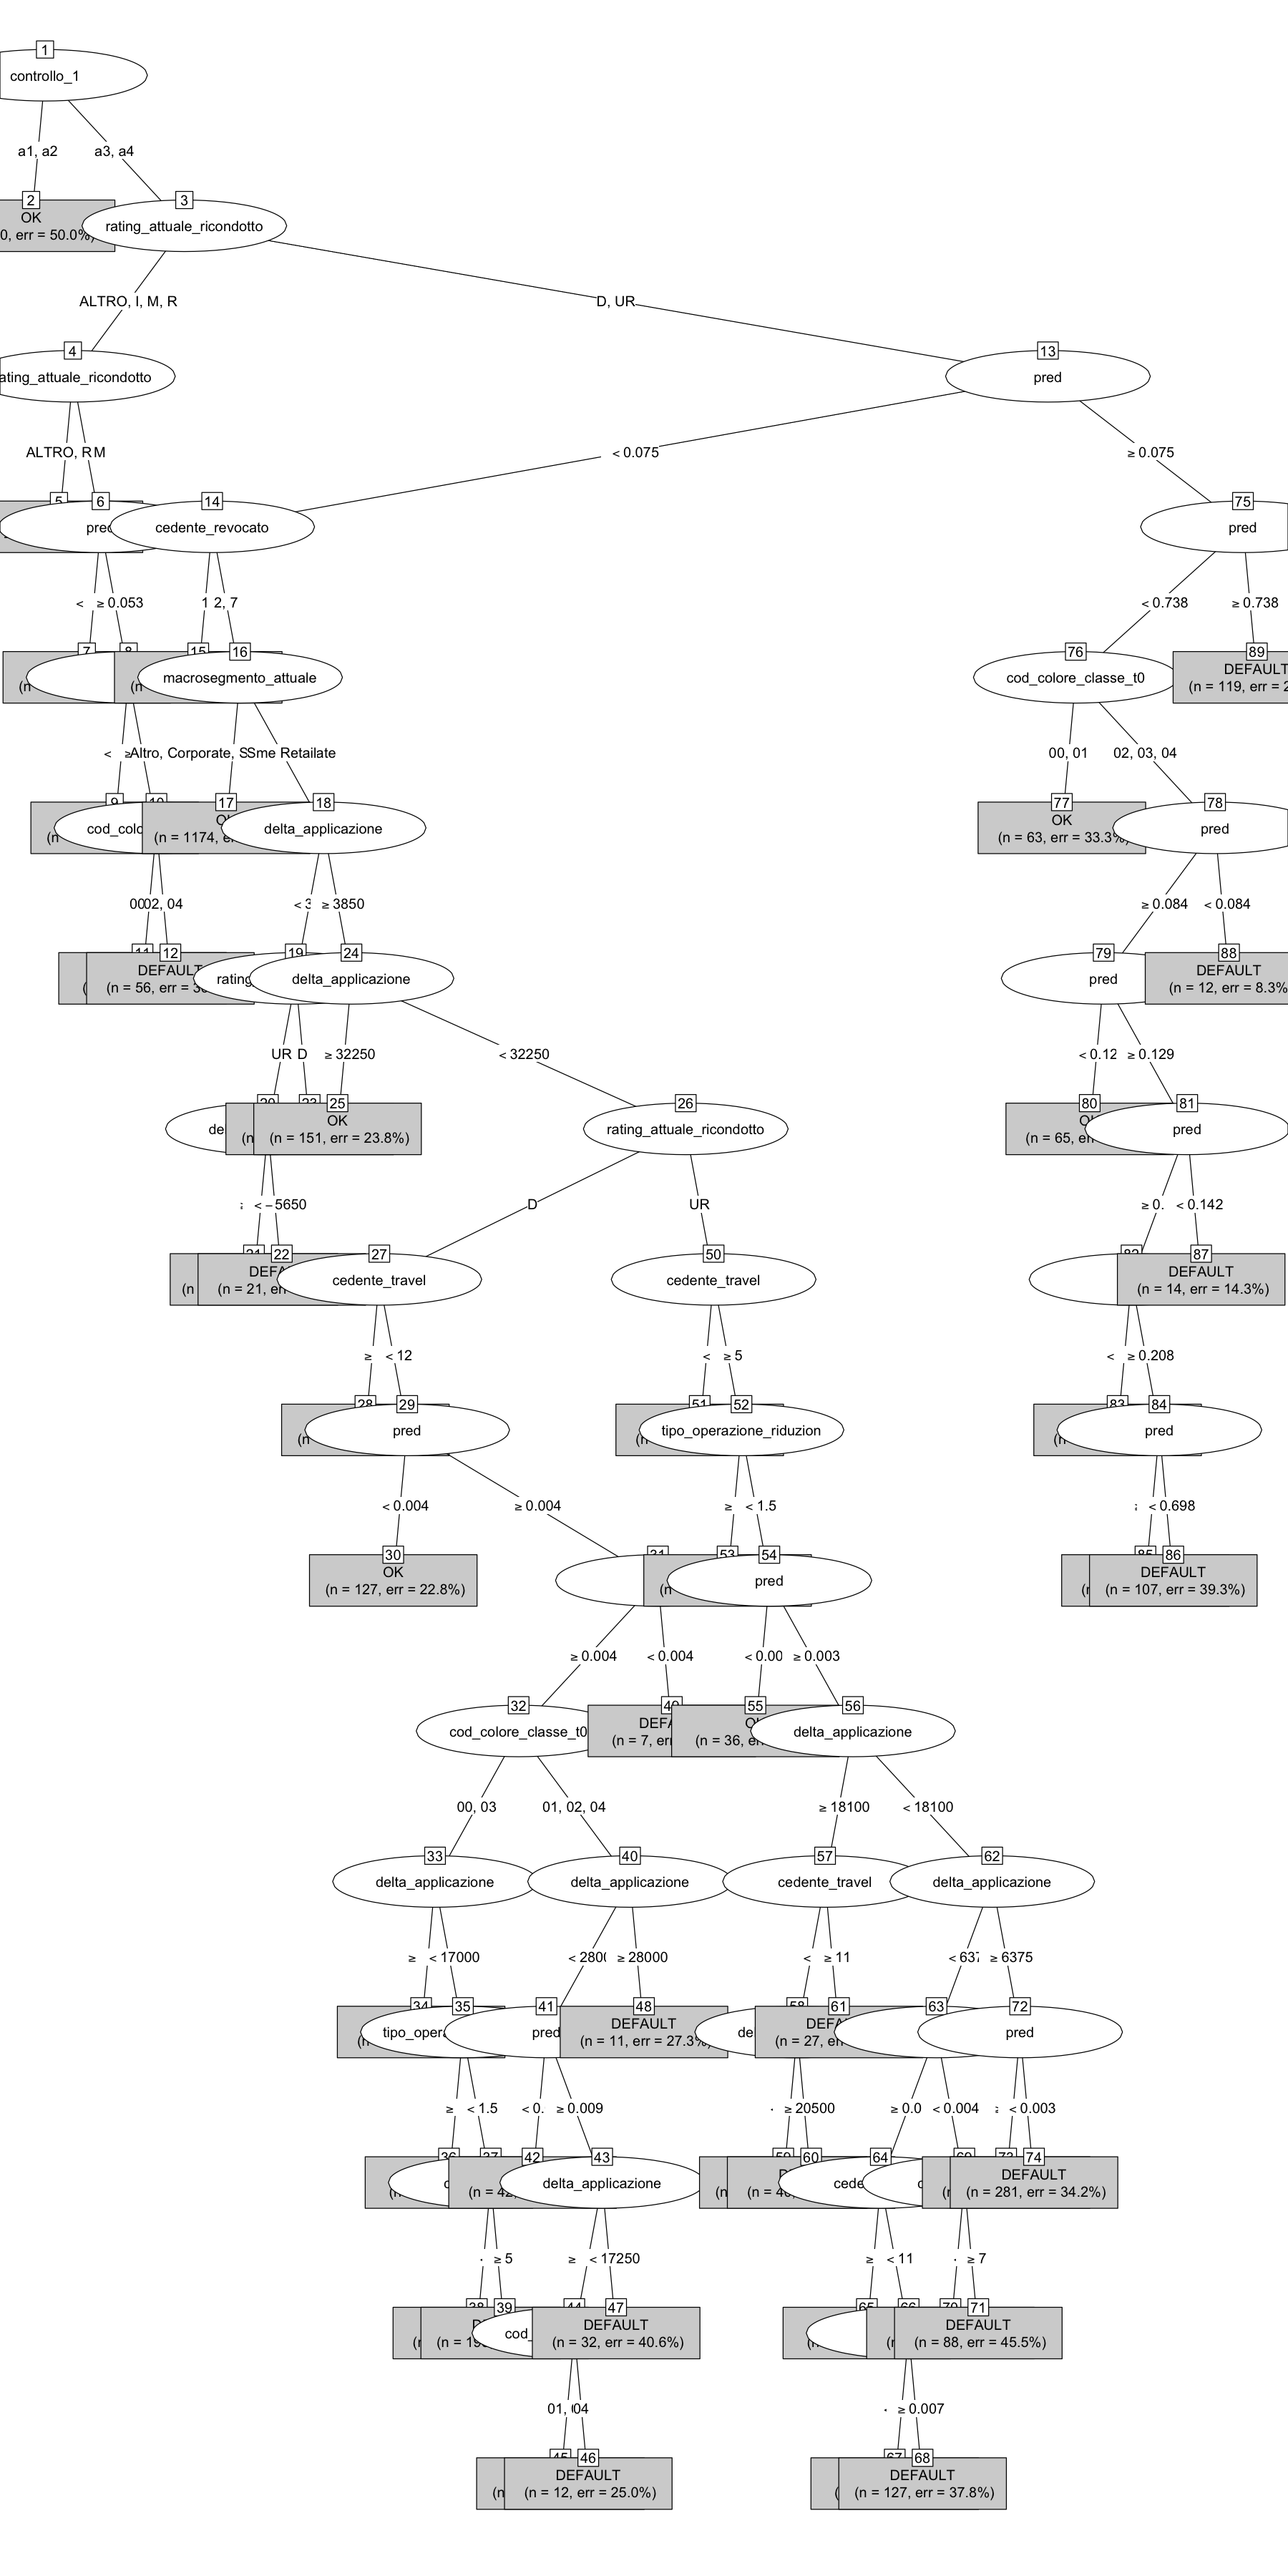

In [65]:
#pdf('prova_xml.pdf')
options(repr.plot.width=15, repr.plot.height=30)
plot(mod_prova)
#dev.off()

In [5]:
rpart.plot(mod_prova, type=2, fallen.leaves=F, yesno=2, extra = 107,box.palette="-RdGn")
#dev.off()

ERROR: Error in rpart.plot(mod_prova, type = 2, fallen.leaves = F, yesno = 2, : Not an rpart object


In [51]:
dt_appo

mat <- model.matrix(~0+dt_appo[,target])
        attr(mat, "dimnames")[[2]] <- levels(master$target)
        master <- cbind(dt_appo, as.data.table(mat))

cedente_revocato,cedente_travel,tipo_operazione_riduzion,ft_factoring,target,pred,esito_finale_vpc,esito_post_giallo,rating_attuale_ricondotto,delta_applicazione,macrosegmento_attuale,cod_colore_classe_t0
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
1,4,1,580,OK,NA,VERDE,VERDE,I,15000,Sme Retail,NA
2,6,1,NA,OK,NA,ROSSO,ROSSO,R,0,Sme Retail,NA
2,6,1,580,OK,0.0006674926,VERDE,VERDE,M,8000,Sme Retail,04
2,6,1,580,OK,0.0173738655,ROSSO,ROSSO,R,0,Sme Retail,NA
2,6,1,580,OK,NA,VERDE,VERDE,M,25000,Sme Retail,04
2,6,1,580,OK,NA,ROSSO,ROSSO,R,0,Sme Retail,NA
2,6,1,580,OK,0.0002058705,VERDE,VERDE,I,1950,Sme Retail,00
1,4,1,580,OK,0.0015030890,VERDE,VERDE,UR,15000,Sme Retail,00
2,16,2,580,OK,0.0029019420,VERDE,VERDE,I,11400,Sme Retail,00


In [ ]:
xgb <- xgboost(data = as.matrix(dt_appo[,..slcols]), label = dt_appo[[target]],
    nrounds=150, max_depth = 5)